Number of replicas: 1
Normal images count: 1349
Pneumonia images count: 3883


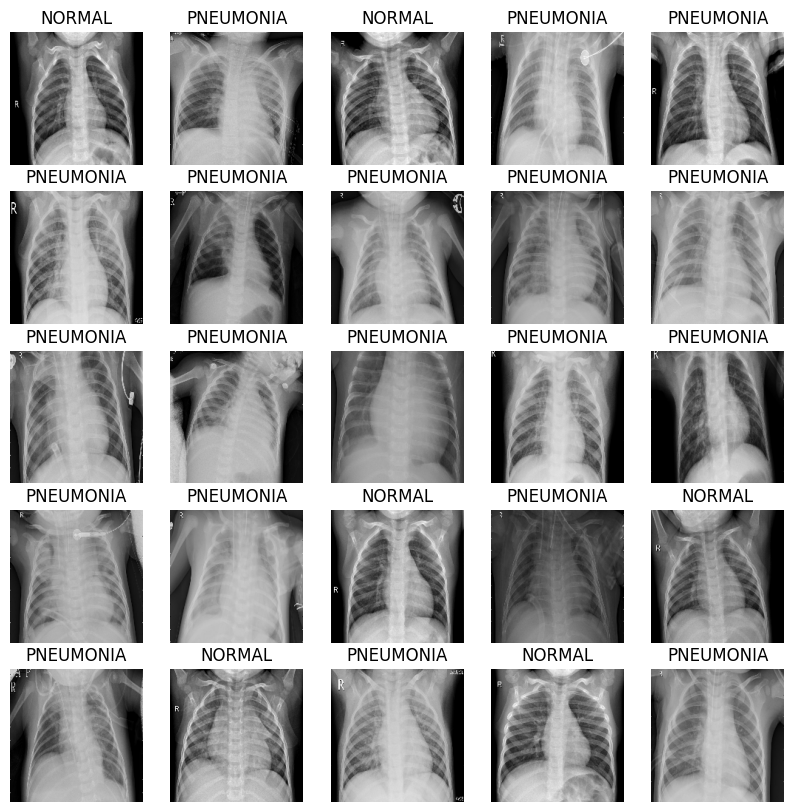

In [21]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# TPU Setup
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

# Load Datasets
train_images = tf.data.TFRecordDataset("gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec")
train_paths = tf.data.TFRecordDataset("gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec")
ds = tf.data.Dataset.zip((train_images, train_paths))

# Count Classes
def count_class(ds, class_name):
    return sum(1 for x in ds if class_name.encode() in x.numpy())

COUNT_NORMAL = count_class(train_paths, "NORMAL")
COUNT_PNEUMONIA = count_class(train_paths, "PNEUMONIA")

print("Normal images count:", COUNT_NORMAL)
print("Pneumonia images count:", COUNT_PNEUMONIA)

# Helper functions
def get_label(file_path):
    parts = tf.strings.split(file_path, "/")
    return parts[-2] == "PNEUMONIA"

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, IMAGE_SIZE)

def process_path(image, path):
    label = get_label(path)
    img = decode_img(image)
    return img, label

ds = ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)

def prepare_for_training(ds, cache=True):
    if cache:
        ds = ds.cache() if not isinstance(cache, str) else ds.cache(cache)
    ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Show sample images
image_batch, label_batch = next(iter(train_ds))
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        plt.title("PNEUMONIA" if label_batch[n] else "NORMAL")
        plt.axis("off")
show_batch(image_batch.numpy(), label_batch.numpy())

# Test Data
test_images = tf.data.TFRecordDataset("gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec")
test_paths = tf.data.TFRecordDataset("gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec")
test_ds = tf.data.Dataset.zip((test_images, test_paths)).map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)


In [22]:
from tensorflow import keras
from tensorflow.keras import layers

In [23]:
def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.MaxPool2D()(x)

In [24]:
def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    return layers.Dropout(dropout_rate)(x)

In [25]:
def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)

    x = conv_block(32, x)
    x = conv_block(64, x)
    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)

    x = conv_block(256, x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [26]:
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

Initial bias: 1.05724


In [27]:
total = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * total / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * total / 2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

In [28]:
print(f"Weight for NORMAL (0): {weight_for_0:.2f}")
print(f"Weight for PNEUMONIA (1): {weight_for_1:.2f}")

Weight for NORMAL (0): 1.94
Weight for PNEUMONIA (1): 0.67


In [29]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.015, decay_steps=100000, decay_rate=0.96, staircase=True)

In [30]:
with strategy.scope():
    model = build_model()
    METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]

In [31]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

In [34]:
def process_path(image, path):
    label = get_label(path)
    label = tf.cast(label, tf.float32)  # ✅ Convert bool to float
    img = decode_img(image)
    return img, label


In [36]:
train_ds = ds.take(4200)
val_ds = ds.skip(4200)
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


In [41]:
print("Test Results:")
model.evaluate(test_ds, return_dict=True)

Test Results:
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 755ms/step - binary_accuracy: 0.7159 - loss: 0.6931 - precision: 0.0000e+00 - recall: 0.0000e+00


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


{'binary_accuracy': 0.375,
 'loss': 0.6931470632553101,
 'precision': 0.0,
 'recall': 0.0}

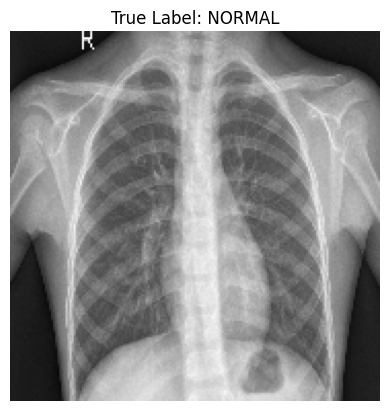

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
This image is 50.00% NORMAL
This image is 50.00% PNEUMONIA


In [46]:
for images, labels in test_ds.take(1):
    image = images[0]
    label = labels[0]

    # Show the image
    plt.imshow(image / 255.0)
    plt.title(f"True Label: {CLASS_NAMES[int(label)]}")
    plt.axis("off")
    plt.show()

    # Make prediction
    prediction = model.predict(tf.expand_dims(image, axis=0))[0][0]

    # Compute class scores
    scores = [1 - prediction, prediction]  # [NORMAL, PNEUMONIA]

    # Print results
    for score, name in zip(scores, CLASS_NAMES):
        print(f"This image is {100 * score:.2f}% {name}")
